In [1]:
import sys
# MC: need to specify path to remo in notebook
local_path_to_repo =  'C:/Users/crows/Documents/GitHub/remo-python'

sys.path.insert(0, local_path_to_repo)

In [2]:
%load_ext autoreload
%autoreload 2
import remo


    (\(\ 
    (>':') Remo server is running: {'version': '0.3.4'}
                


## Get Dataset

In [4]:
remo.list_datasets()

[Dataset 1 - 'Vova's dataset',
 Dataset 2 - 'open images detection',
 Dataset 3 - 'Subset of OID',
 Dataset 4 - 'train',
 Dataset 6 - 'test',
 Dataset 12 - 'oid 100',
 Dataset 13 - 'open images sample data',
 Dataset 19 - 'oid building ',
 Dataset 21 - 'oid building and car',
 Dataset 22 - 'oid building car detection']

In [13]:
my_dataset = remo.get_dataset(21)

In [14]:
my_dataset.view()

Open http://localhost:8000/datasets/21


![SegmentLocal](scroll.gif "segment")

In [6]:
my_dataset.annotation_sets

[Annotation set 12 - 'Image classification', task: Image classification, #classes: 2]

In [11]:
my_dataset.view_annotation_statistics()

Open http://localhost:8000/annotation-detail/12/intro


![SegmentLocal](annotation.gif "segment")

## Train-Test Split

In [7]:
len(my_dataset)

197

In [8]:
val = my_dataset[0:len(my_dataset) // 3]

In [9]:
train = my_dataset[len(my_dataset) // 3:]

In [10]:
val.export_annotation_to_csv('val.csv')

In [11]:
train.export_annotation_to_csv('train.csv')

In [12]:
val.view_image(val.images[0].id)

Open http://localhost:8000/image/1592?datasetId=21


In [13]:
val.list_images(limit=3)

[{'id': 1592, 'name': '0003911c3e08eb1d.jpg'},
 {'id': 1593, 'name': '0008e569c781c919.jpg'},
 {'id': 1594, 'name': '0007efdd465a14b8.jpg'}]

## Prepare for Image Classification

### Arrange Train & Validation Data

In [16]:
import glob
import os
from shutil import copyfile
import pandas as pd

def arrange_folders(phase, cls, root='cls_dataset'):
    """
    Given dataframe and directory path containing the images
    Arranges samples as given below: 
        root/phase/class/xxx.ext
    Args:
        root: string. Root directory path.
        phase: string. 'train' or 'val'
        cls: string.
    """
    df = pd.read_csv(phase + '.csv')
    images = df.loc[df['class'] == cls].file_name.values
    phase_path = path.join(root, phase)
    if not os.path.exists(phase_path):
        os.mkdir(phase_path)
    class_path = path.join(phase_path, cls)
    if not os.path.exists(class_path):
        os.mkdir(class_path)
    for im in images:
        copyfile(path.join(root, im), path.join(class_path, im))
        

In [17]:
arrange_folders(phase='val', cls='Car', root='cls_dataset')

In [18]:
arrange_folders(phase='val', cls='Building', root='cls_dataset')

In [19]:
arrange_folders(phase='train', cls='Car', root='cls_dataset')

In [20]:
arrange_folders(phase='train', cls='Building', root='cls_dataset')

## PyTorch

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
train_dataset = datasets.ImageFolder(os.path.join('cls_dataset/', 'train'), 
                                     transforms.Compose(
                                         [transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(), 
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

In [24]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [25]:
val_dataset = datasets.ImageFolder(os.path.join('cls_dataset/', 'val'), 
                                   transforms.Compose(
                                       [transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

In [26]:
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

In [27]:
datasizes = {x: len(val_dataset) if x == 'val' else len(train_dataset) for x in ['train','val'] }

In [28]:
datasizes 

{'train': 133, 'val': 67}

In [29]:
# load pre-trained resnet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

num_classes = len(train_dataset.classes)
# reset the final fully connected layer
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


best_model_weights = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

In [30]:
epochs = 20

In [32]:
for epoch in range(epochs):      
    #print(f"Epoch {epoch}/{epochs-1}")
    #print(" ")
    for phase in ['train', 'val']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model_ft.train()
            dataloader = train_dataloader
        else:
            model_ft.eval()
            dataloader = val_dataloader


        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model_ft(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        else:
            epoch_acc = running_corrects.double() / datasizes[phase]
            epoch_loss = running_loss / datasizes[phase]
            #print(f"{phase} loss: {epoch_loss}")
            #print(f"{phase} acc: {epoch_acc}")

        if phase == 'val':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model_ft.state_dict())

print(f'Best Val Acc: {best_acc}')
model_ft.load_state_dict(best_model_weights)

Best Val Acc: 0.9701492537313433


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
class_names = train_dataset.classes

In [37]:
class_names

['Building', 'Car']

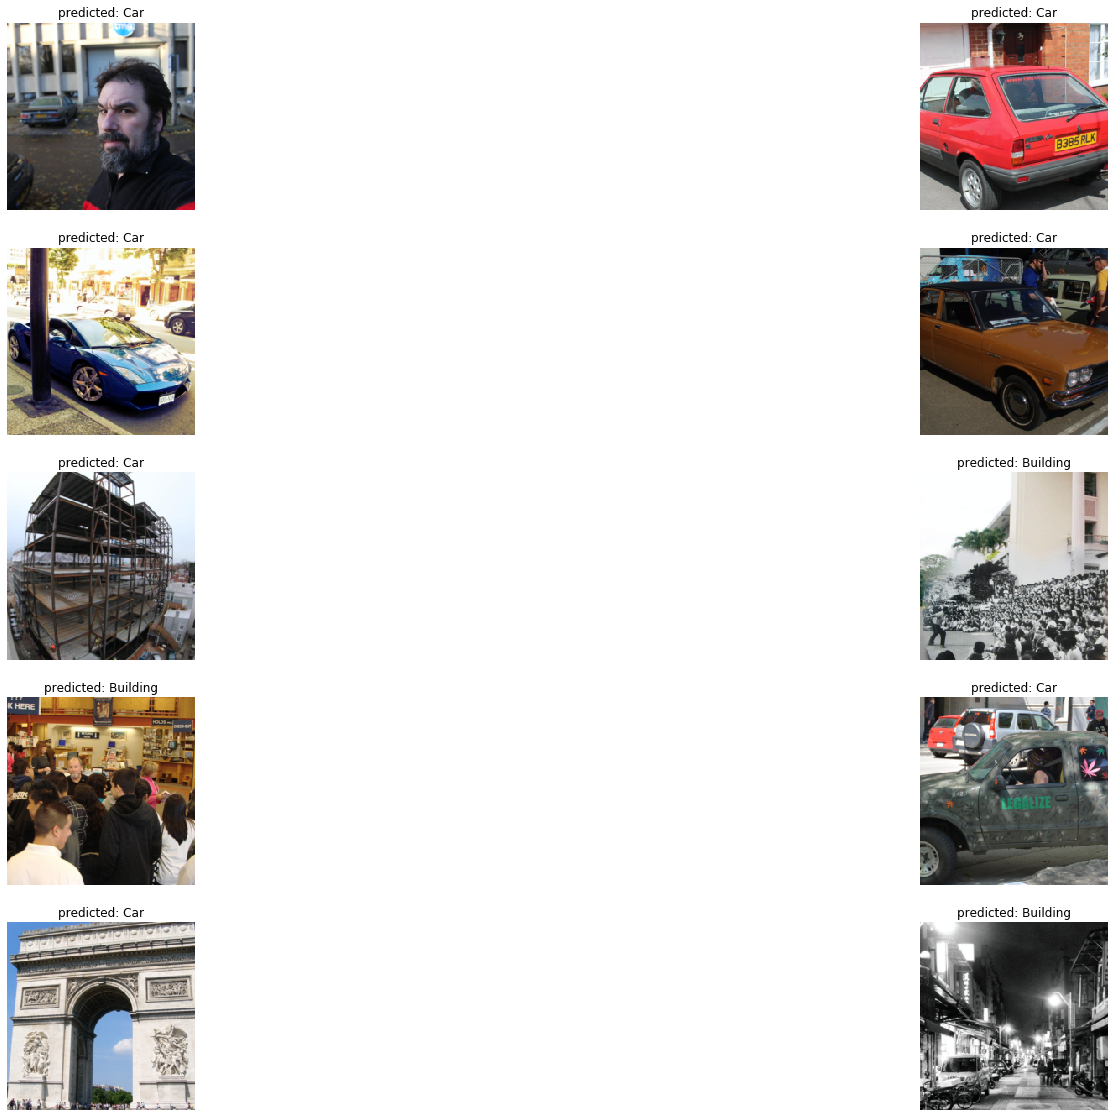

In [36]:
num_images = 0
fig = plt.figure(figsize=(30, 20))

with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            if num_images == 10:
                break
            num_images += 1
            ax = plt.subplot(10//2, 2, num_images)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imgs = inputs.cpu().data[j]
            imgs = imgs.numpy().transpose((1, 2, 0))
            imgs = np.array([0.229, 0.224, 0.225])* imgs + np.array([0.485, 0.456, 0.406])
            imgs = np.clip(imgs, 0, 1)
            plt.imshow(imgs)
     

            